In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

from sklearn import svm
from sklearn import linear_model

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from IPython.display import Markdown, display
import pandas as pd

import os
print(os.listdir("./input"))

['historical_transactions.csv', '.ipynb_checkpoints', 'new_merchant_transactions.csv', 'merchants.csv', 'sample_submission.csv', 'test.csv', 'Data_Dictionary.xlsx', '.gitignore', 'train.csv']


In [2]:
train_df = pd.read_csv('./input/train.csv', sep=',', parse_dates=["first_active_month"])
# Don't really need this file (no target column)
test_df = pd.read_csv('./input/test.csv', sep=',', parse_dates=["first_active_month"])

In [3]:
print(train_df.target.describe())

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64


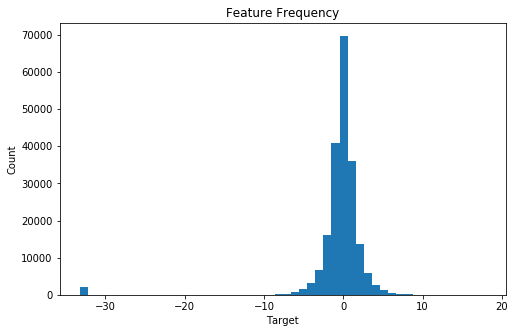

In [4]:
plt.figure(figsize=(8, 5))
plt.hist(train_df.target.values, bins=50)
plt.title('Feature Frequency')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

/home/khanna/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


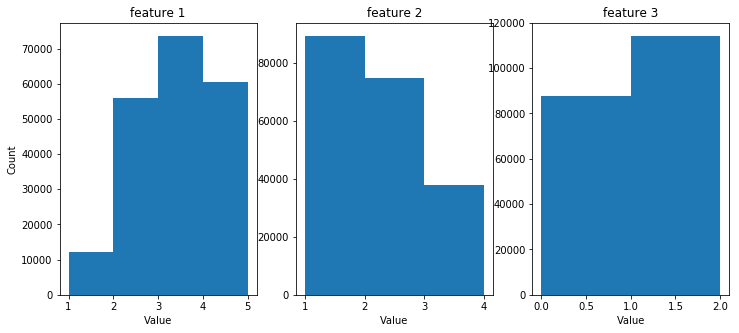

In [5]:

fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12.0, 5.0))

ax1.hist(train_df.feature_1.values, bins=[1,2,3,4,5])
ax1.set_title('feature 1')
ax1.set_xlabel('Value')
ax1.set_ylabel('Count')

ax2.hist(train_df.feature_2.values, bins=[1,2,3,4])
ax2.set_title('feature 2')
ax2.set_xlabel('Value')
# ax2.set_ylabel('Count')

ax3.hist(train_df.feature_3.values, bins=[0,1,2])
ax3.set_title('feature 3')
ax3.set_xlabel('Value')
# ax3.set_ylabel('Count')


fig1.show()

In [6]:

# Grab only the features since ndarrays need to be homogeneous
training_df = train_df[['feature_1', 'feature_2', 'feature_3']]
labels_df = train_df[['target']]

# Split data in to train and test (80/20)
# This should be made to grab random rows
data_len = len(training_df)
train_data = training_df.values[:int(data_len*.8)]
train_labels = labels_df.values.flatten()[:int(data_len*.8)]
test_data = training_df.values[int(data_len*.8):]
test_labels = labels_df.values.flatten()[int(data_len*.8):]

In [7]:
print(data_len)
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)
print(train_data.shape[0] + test_data.shape[0])

print()

201917
(161533, 3)
(161533,)
(40384, 3)
(40384,)
201917



In [8]:
train_df['first_active_month'] = pd.to_datetime(train_df['first_active_month'])
test_df['first_active_month'] = pd.to_datetime(test_df['first_active_month'])
train_df['elapsed_time'] = (datetime.date(2018, 2, 1) - train_df['first_active_month'].dt.date).dt.days
test_df['elapsed_time'] = (datetime.date(2018, 2, 1) - test_df['first_active_month'].dt.date).dt.days

train_df['outliers'] = 0
train_df.loc[train_df['target'] < -30, 'outliers'] = 1



target = train_df['target']
del train_df['target']

train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,outliers
0,2017-06-01,C_ID_92a2005557,5,2,1,245,0
1,2017-01-01,C_ID_3d0044924f,4,1,0,396,0
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549,0
3,2017-09-01,C_ID_186d6a6901,4,3,0,153,0
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,92,0


In [9]:
X = train_data
y = train_labels

X_test = test_data
y_test = test_labels

# clf = svm.SVR(gamma='auto')
# clf.fit(X, y) 



In [10]:
# y_pred = clf.predict(y_test)
# mean_squared_error(y_test, y_pred)

In [11]:
# reg = linear_model.Ridge(alpha=.5)
reg = linear_model.LinearRegression()
reg.fit(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [13]:
y_pred_reg = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred_reg)

y_mean = train_labels.mean()
y_test_mean = test_labels.mean()

print("After fitting Linear Regression, the Mean Squared Error is: {:0.3f}".format(mse))
print("The mean of our training label is {:0.3f} and for testing {:0.3f}".format(y_mean, y_test_mean))



After fitting Linear Regression, the Mean Squared Error is: 15.363
The mean of our training label is -0.392 and for testing -0.401
